## Calculate AOU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import os
import cftime
import gsw

In [2]:
dir_in = '/Users/nd20983/Documents/data/'
data_list = ['xpvha','xpvhb','xpvhc','xpvhr','xpvhw',]
dscb_list = ['GETECH','Scotese','Robertsons','GET_RC','GET_LC']
file_tail = 'o.pfclann.nc'
ds_list = []
for data in data_list:
    filename = os.path.join(dir_in, data + file_tail)
    ds = xr.open_dataset(filename, decode_times=False)
    ds['t'].attrs['units'] = 'days since 2850-12-01 00:00:00'
    ds = xr.decode_cf(ds)
    ds_list.append(ds)


/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_4648/3105784096.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_4648/3105784096.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_4648/3105784096.py:10: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning

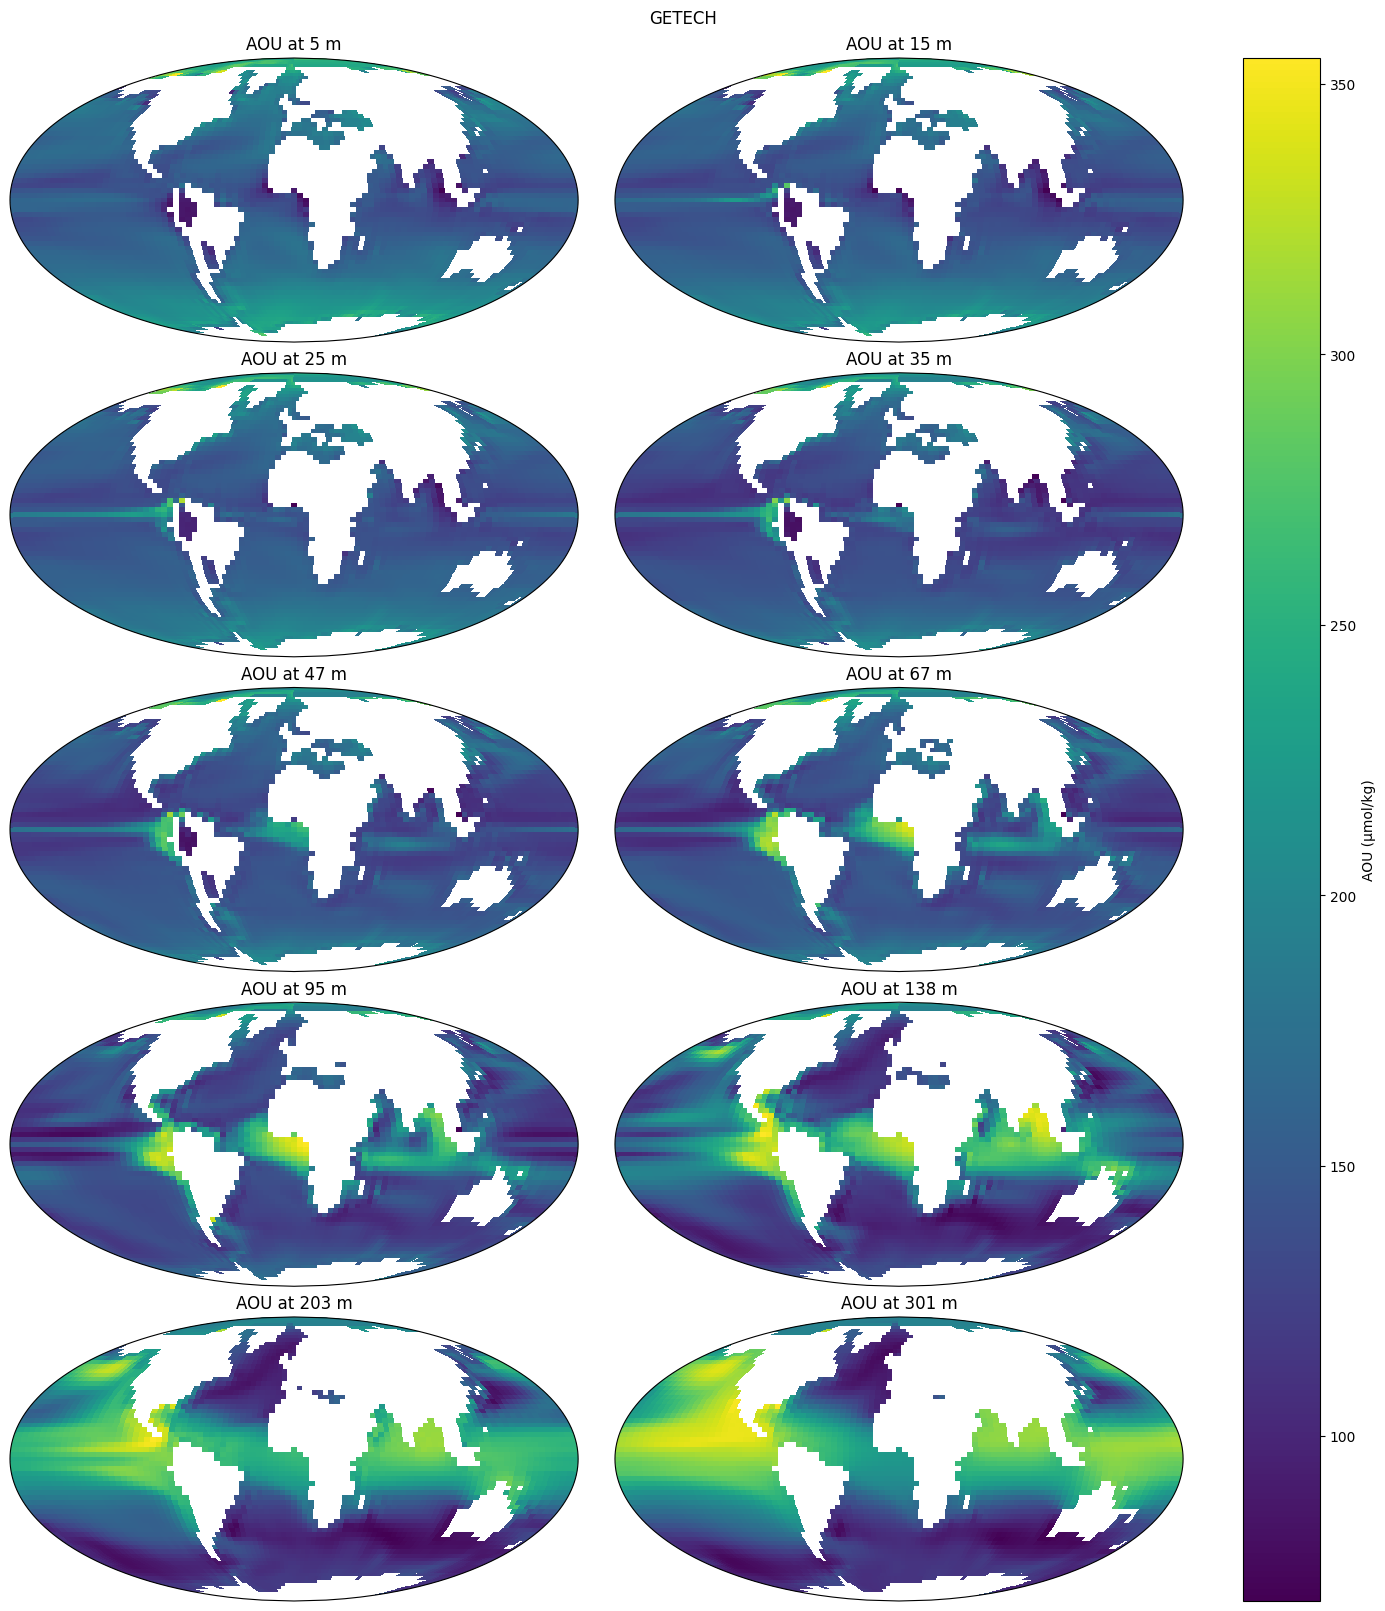

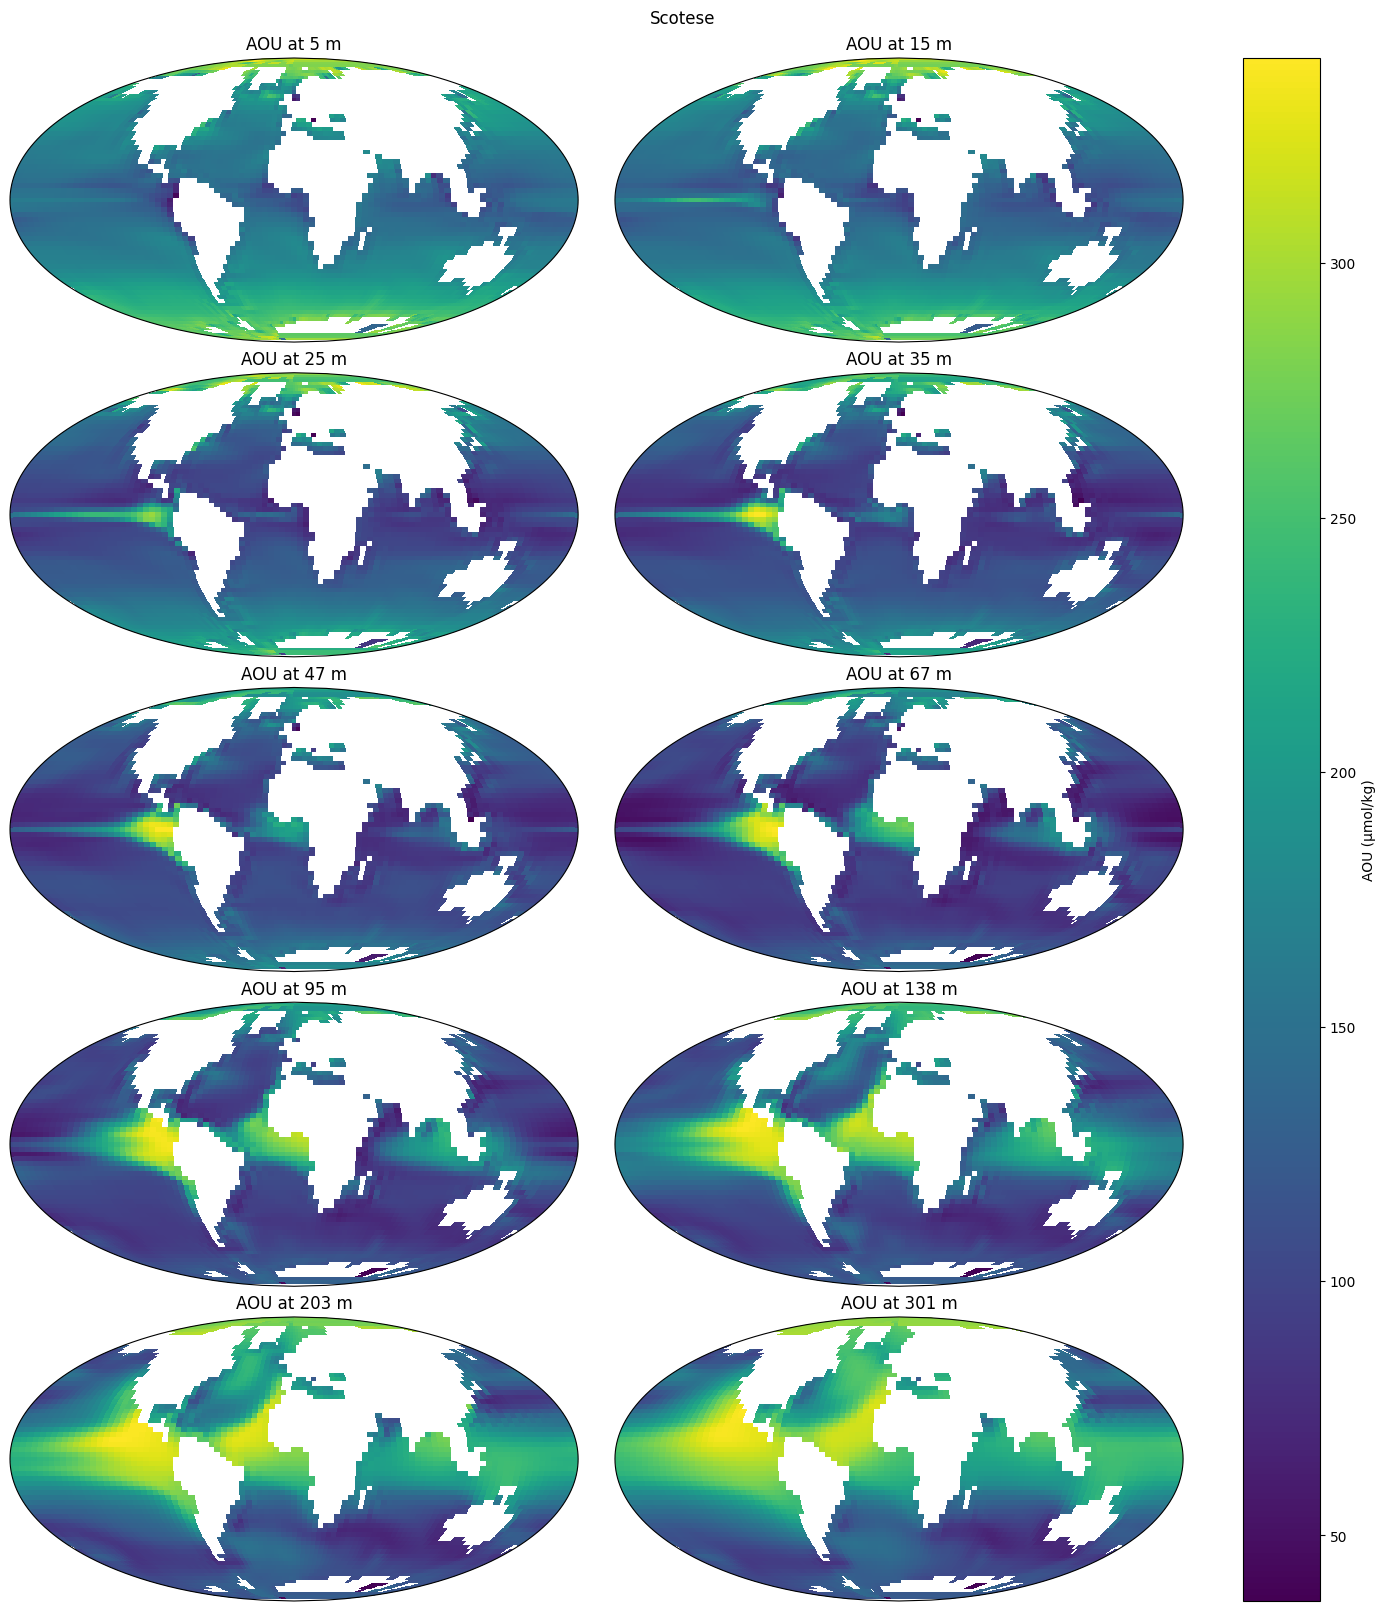

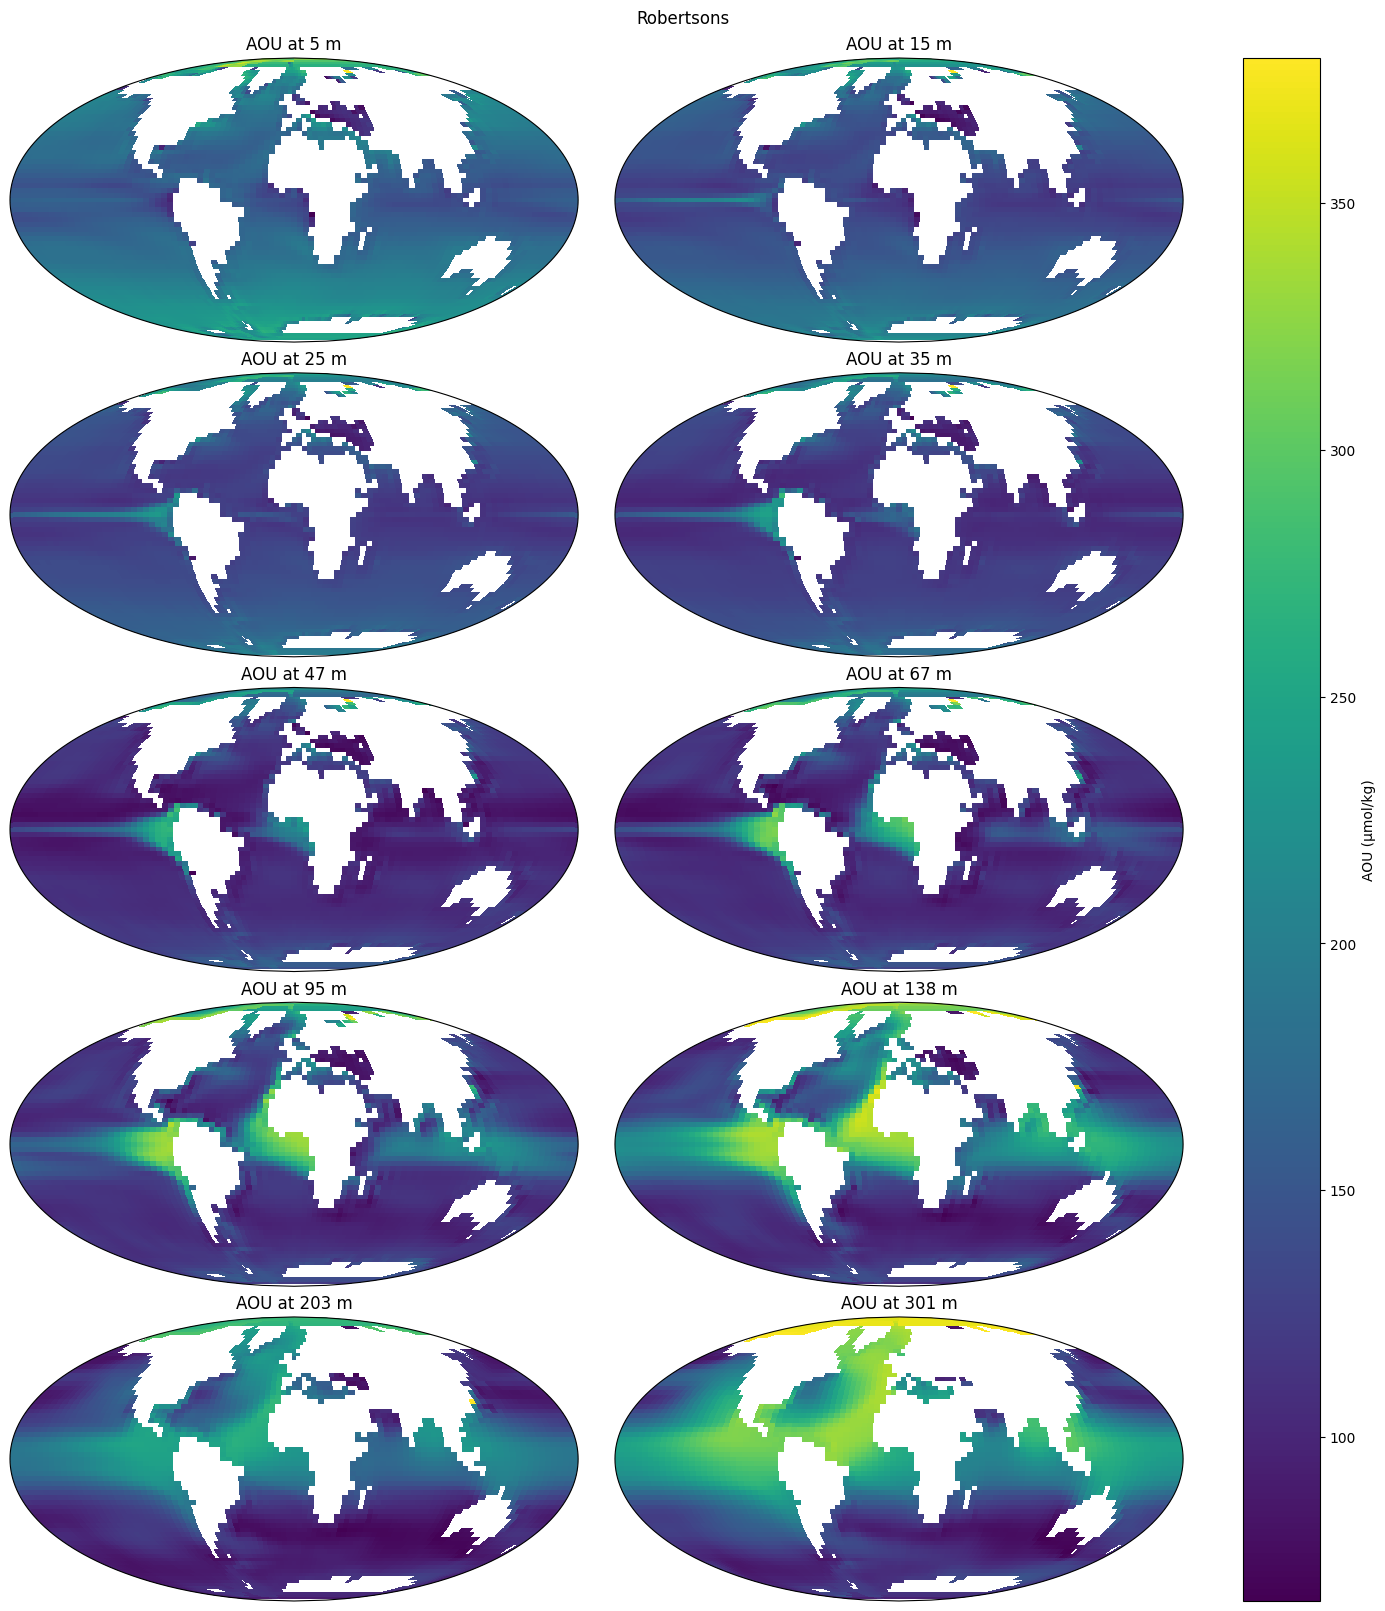

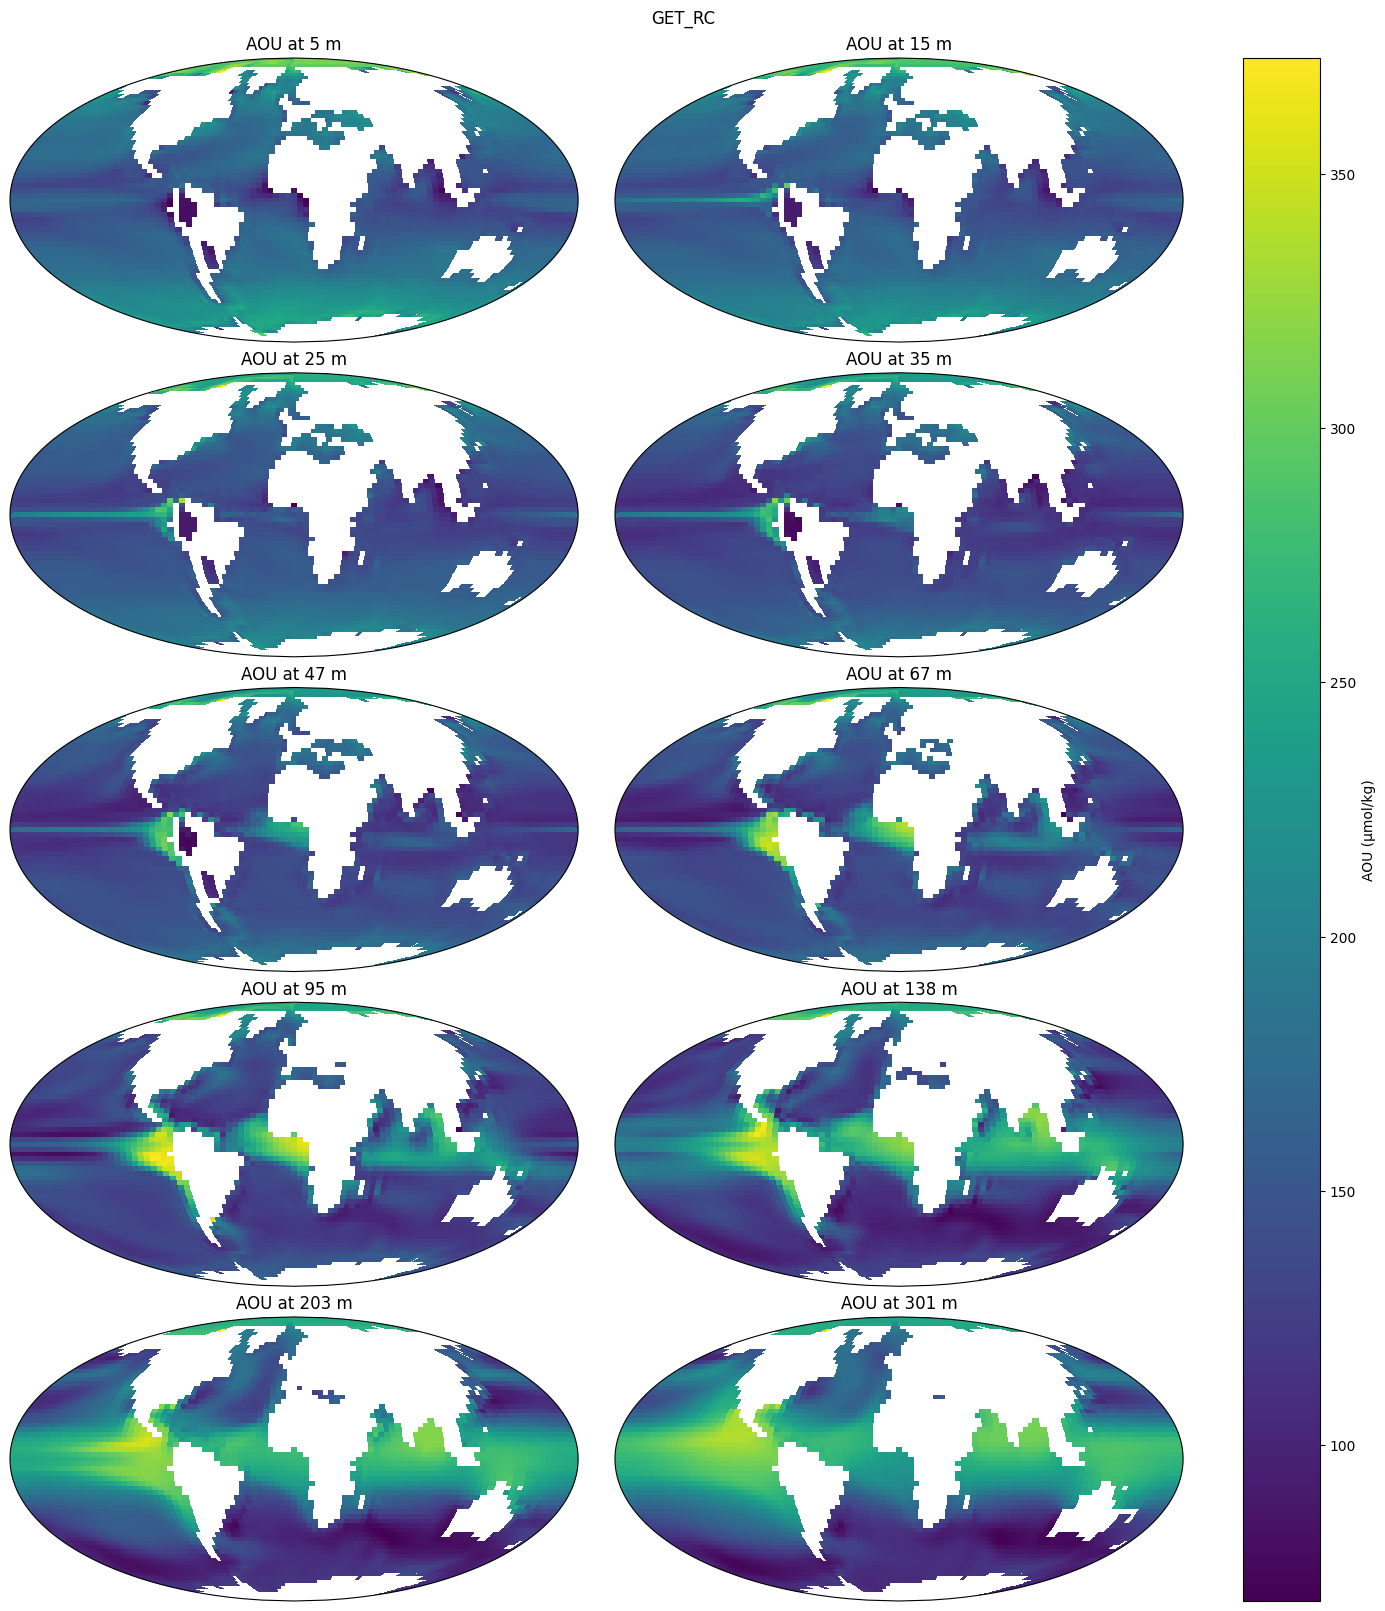

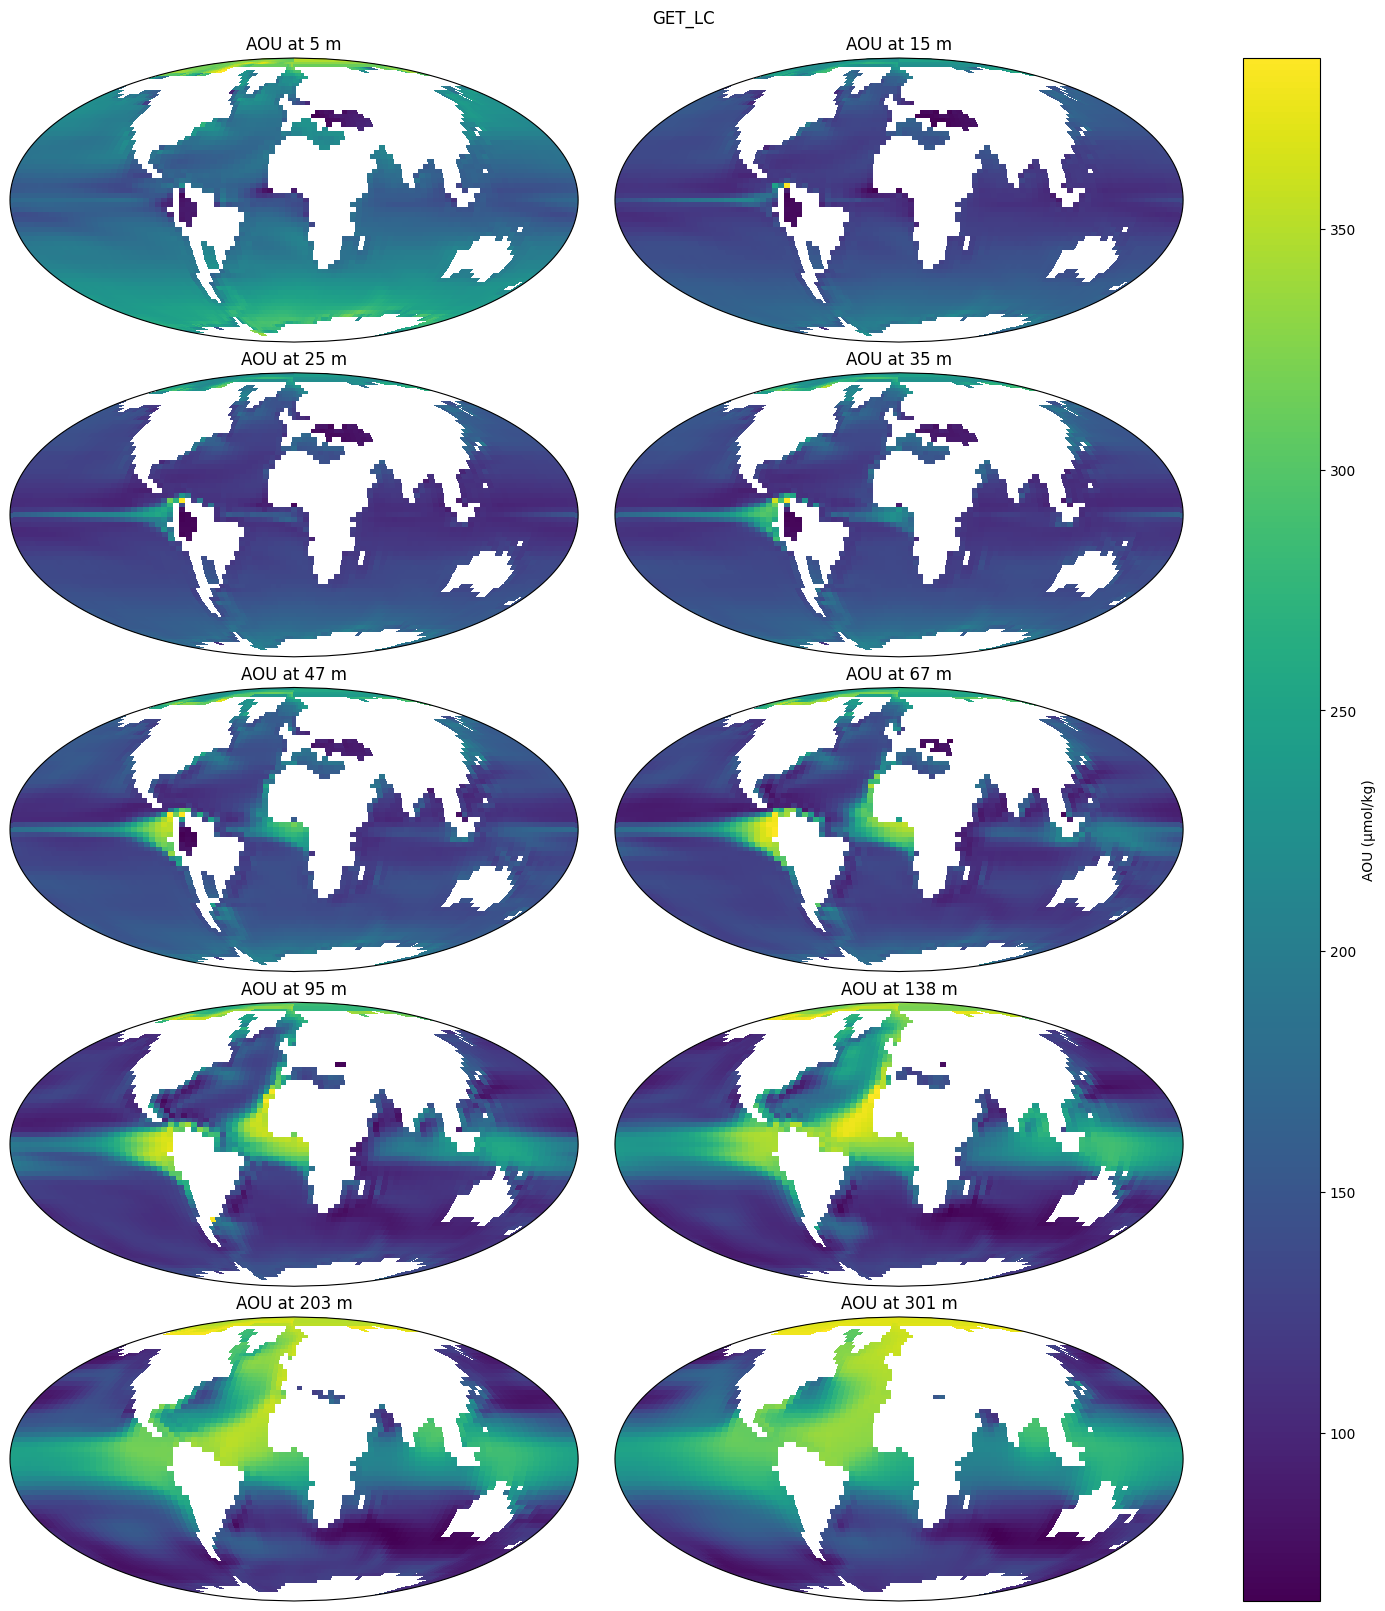

In [ ]:
# loop over ds_list
for i in range(len(ds_list)):
    # load dataset
    ds = ds_list[i]
    # get essential variables
    temp = ds['temp_mm_dpth']
    salt = ds['salinity_mm_dpth']
    oxygen = ds['O2_mm_dpth']
    # get coordinates
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth_2']
    # broadcast lat/lon to match 3D shape (seems unnecessary)

    # convert to numpy arrays for gsw
    SP = salt.values
    pt = temp.values
    # lat_vals = lat.values
    # lon_vals = lon.values

    # compute oxygen solubility (in umol/kg)
    O2_sat = gsw.O2sol_SP_pt(SP, pt)

    # compute AOU
    aou = xr.DataArray(O2_sat - oxygen.values, coords=oxygen.coords, dims=oxygen.dims)
    aou.name = 'AOU'
    aou.attrs["units"] = "µmol/kg"
    aou.attrs["long_name"] = "Apparent Oxygen Utilization"

    # add to dataset
    ds['AOU'] = aou

    # plots for vertical layers
    cols = 2
    rows = 5
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,16), layout='constrained',
                            subplot_kw={'projection': ccrs.Mollweide()})
    for row in range(rows):
        for col in range(cols):
            ax = axs[row, col]
            d = row*2 + col
            im = ax.pcolormesh(lon, lat, aou.isel(t=0, depth_2=d), shading='auto', cmap='viridis',
                            transform=ccrs.PlateCarree())
            ax.set_title(f"AOU at {int(depth[d].values)} m")
    # plt.colorbar(im, label='AOU (µmol/kg)')
    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)')
    fig.suptitle(dscb_list[i],)
    
    # plots for zonal means

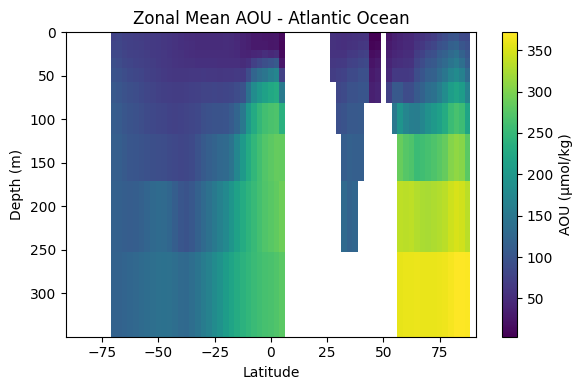

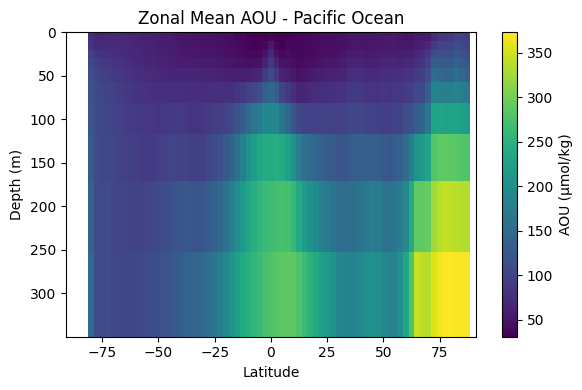

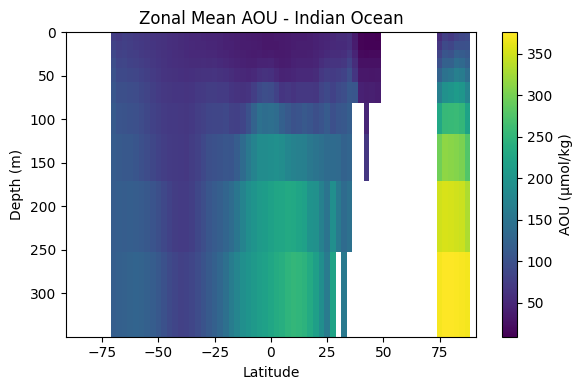

In [25]:
# Ocean basin masks
basins = {
    "Atlantic": ((lon >= -100) & (lon <= 20)),
    "Pacific": ((lon >= 120) | (lon <= -70)),
    "Indian": ((lon >= 20) & (lon <= 120)),
}

# Zonal mean plots
for name, mask in basins.items():
    aou_basin = aou.where(mask, drop=True)
    zonal_mean = aou_basin.mean(dim="longitude", skipna=True)
    plt.figure(figsize=(6, 4))
    zonal_mean.plot(y="depth_2", yincrease=False, cmap="viridis", cbar_kwargs={"label": "AOU (µmol/kg)"})
    plt.title(f"Zonal Mean AOU - {name} Ocean")
    plt.xlabel("Latitude")
    plt.ylabel("Depth (m)")
    plt.tight_layout()
    plt.show()
